Magnetic trap measurement
===


In [1]:
import matplotlib.pyplot as plt
import numpy as np

from ndscan_utils import NDScanDataset

from pint import UnitRegistry
ureg = UnitRegistry()

In [2]:
file = "000002942-MeasureMagneticTrapFrag.h5"
d = NDScanDataset.from_file(file)
print(d.summarise())

Scan settings

 - Axes:
   - Time to wait in the dark for the magnetic trap (measure_magnetic_trap.MeasureMagneticTrapFrag.dark_time@*):
     25.0 ms to 60000.0 ms, 40 points
 - Number of repeats: 10
 - Randomise order globally: False


Overrides

 - Time to drain into the mag trap for: 5000.0 ms
   (measure_magnetic_trap.MeasureMagneticTrapFrag.magnetic_trap_loading_time@*)
 - Number of points to take in photodiode trace: 200.0
   (measure_magnetic_trap.MeasureMagneticTrapFrag.num_trace_points@*)
 - Delay between points in the photodiode trace: 1.0 ms
   (measure_magnetic_trap.MeasureMagneticTrapFrag.delay_between_trace_points@*)




In [3]:
loading_time, voltage_trace = d.get_1d_scan_data("photodiode_voltage")

In [4]:
# Chuck away the first 100ms and average the last 100ms
mean_voltage_traces = np.mean(voltage_trace[:, 100:], 1)

In [5]:
# Calculate standard deviations and means for each bin
unique_loading_times = np.unique(loading_time)

times = []
flourescence = []
flourescence_1s = []

for time in unique_loading_times:
    k = loading_time == time

    times.append(time)
    flourescence.append(np.mean(mean_voltage_traces[k]))
    flourescence_1s.append(np.std(mean_voltage_traces[k]) / np.sqrt(sum(k)))

times = np.array(times)
flourescence = np.array(flourescence)
flourescence_1s = np.array(flourescence_1s)

In [6]:
# Load data from birmingham
bham_times = np.array([ 1,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
bham_signal = 1e-3*np.array([995.0, 830.0, 602.0, 448.0, 364.0, 252.0, 216.0, 148.0, 100.0, 76.0, 44.0])
bham_signal_serr = 1e-3*np.array([
    74.44237144709098, 8.246211251235321, 60.07772743149772, 30.463092423455635, 5.163977794943222, 16.812693617224657, 20.132891827388665, 6.928203230275509, 18.90326250501043, 11.547005383792516, 7.659416862050705
              ])

In [7]:
from scipy.optimize import curve_fit


def f(t, bg, A, tau):
    return bg + A * np.exp(-t / tau)


p0 = [
    min(mean_voltage_traces),
    max(mean_voltage_traces) - min(mean_voltage_traces),
    0.5 * (max(loading_time) - min(loading_time)),
]

params, cov = curve_fit(
    f, times, flourescence, p0=p0, sigma=flourescence_1s, absolute_sigma=True
)
bg, A, tau = params
bg_1s, A_1s, tau_1s = np.sqrt(np.diag(cov))

In [8]:
params_bham, cov_bham = curve_fit(
    f, bham_times, bham_signal, p0=p0, sigma=bham_signal_serr, absolute_sigma=True
)
bg_bham, A_bham, tau_bham = params_bham
bg_bham_1s, A_bham_1s, tau_bham_1s = np.sqrt(np.diag(cov_bham))

In [9]:
# Convert to bg-corrected "arbitary units" fluorescence signals

flourescence_icl_ref = f(0, *params) - bg
flourescence_icl_au = (flourescence - bg) / flourescence_icl_ref
flourescence_icl_au_1s = flourescence_1s / flourescence_icl_ref

flourescence_bham_ref = f(0, *params_bham) - bg_bham
flourescence_bham_au = (bham_signal - bg_bham) / flourescence_bham_ref
flourescence_bham_au_1s = bham_signal_serr / flourescence_bham_ref

fit_t = np.linspace(min(loading_time), max(loading_time), 1000)
icl_fit = (f(fit_t, *params) - bg) / flourescence_icl_ref
bham_fit = (f(fit_t, *params_bham) - bg_bham) / flourescence_bham_ref

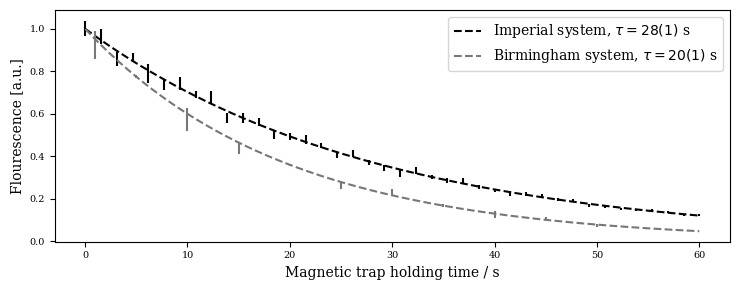

In [10]:
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')


plt.figure(figsize=(7.5, 3))

plt.errorbar(times, flourescence_icl_au, flourescence_icl_au_1s, linestyle="", color='k')
h_icl, = plt.plot(fit_t, icl_fit, "--", color='k')
plt.errorbar(bham_times, flourescence_bham_au, flourescence_bham_au_1s, linestyle="", color='#777')
h_bham, = plt.plot(fit_t, bham_fit, "--", color="#777")
plt.grid(False)
plt.xlabel("Magnetic trap holding time / s")
plt.ylabel("Flourescence [a.u.]")
# plt.title(
#     f"Atoms remaining in magnetic trap - RID{RID} - {len(mean_voltage_traces)} traces"
# )

plt.savefig("magnetic_trap_lifetime.svg")

plt.legend([h_icl, h_bham], [
    f"Imperial system, $\\tau={tau:.0f}({tau_1s:.0f})$ s",
    f"Birmingham system, $\\tau={tau_bham:.0f}({tau_bham_1s:.0f})$ s",    
])

plt.tight_layout()

plt.savefig("magnetic_trap_lifetime.svg")
plt.savefig("magnetic_trap_lifetime.pdf")

In [11]:
tau = tau * ureg.second
tau_1s = tau_1s * ureg.second

tau_bham = tau_bham * ureg.second
tau_bham_1s = tau_bham_1s * ureg.second

tau

28.26553918322707 <Unit('second')>

In [12]:
tau_1s

0.9690910426567664 <Unit('second')>

In [13]:
tau_bham

19.52690616865505 <Unit('second')>

In [14]:
tau_bham_1s

0.7352521912364705 <Unit('second')>

In [15]:
# These are extracted graphically from figure 3a in 
# DOI: 10.1103/PhysRevA.67.011401
paper_points = [
(7.180576631259485e-9, 3.0563583815028905),
(8.012139605462825e-10, 0.1777456647398834)
]

calibration_from_paper = (paper_points[1][1] - paper_points[0][1])/(paper_points[1][0] - paper_points[0][0])
calibration_from_paper = calibration_from_paper * ureg("s^-1 / torr")

In [16]:
pressure = 1 / (tau * calibration_from_paper)
pressure.to("mbar")

1.0452972285837206e-10 <Unit('millibar')>

In [17]:
pressure_1s = (tau_1s / tau) * pressure
pressure_1s.to("mbar")

3.583827552582259e-12 <Unit('millibar')>

In [18]:
pressure_bham = 1 / (tau_bham * calibration_from_paper)
pressure_bham.to("mbar")

1.513086073004203e-10 <Unit('millibar')>

In [19]:
pressure_bham_1s = (tau_bham_1s / tau) * pressure_bham
pressure_bham_1s.to("mbar")

3.935887596178919e-12 <Unit('millibar')>